In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_dir = 'data'
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Create train and test directories
os.makedirs(os.path.join(train_dir, 'with_mask'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'without_mask'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'with_mask'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'without_mask'), exist_ok=True)

# Function to split and copy images
def split_and_copy_images(src_dir, train_dst_dir, test_dst_dir, test_size=0.2):
    images = os.listdir(src_dir)
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(train_dst_dir, img))
    
    for img in test_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(test_dst_dir, img))

# Split and copy images for 'with_mask' class
split_and_copy_images(with_mask_dir, os.path.join(train_dir, 'with_mask'), os.path.join(test_dir, 'with_mask'))

# Split and copy images for 'without_mask' class
split_and_copy_images(without_mask_dir, os.path.join(train_dir, 'without_mask'), os.path.join(test_dir, 'without_mask'))

print("Dataset split into training and testing sets successfully!")

Dataset split into training and testing sets successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [7]:
# Define paths
train_dir = 'data/train'
test_dir = 'data/test'

# Image dimensions
img_width, img_height = 150, 150
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill missing pixels
)

# Only rescale for validation data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Binary classification (with_mask, without_mask)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [4]:
# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the output
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

NameError: name 'img_width' is not defined

In [34]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Load MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


C:\Users\ThDarKSouL\AppData\Local\Temp\ipykernel_3780\4080284864.py:37: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 517ms/step - accuracy: 0.8439 - loss: 0.4349 - val_accuracy: 0.9847 - val_loss: 0.0463
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9375 - loss: 0.1429 - val_accuracy: 0.9834 - val_loss: 0.0454
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 519ms/step - accuracy: 0.9540 - loss: 0.1212 - val_accuracy: 0.9887 - val_loss: 0.0360
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9375 - loss: 0.1782 - val_accuracy: 0.9894 - val_loss: 0.0338
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.9631 - loss: 0.0991 - val_accuracy: 0.9914 - val_loss: 0.0315
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 148s 590ms/step - accuracy: 0.9441 - loss: 0.1495 - val_accuracy: 0.9874 - val_loss: 0.0355
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9688 - loss: 0.1929 - val_accuracy: 0.9874 - val_loss: 0.0359
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - accuracy: 0.9581 - loss: 0.1166 -

48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9899 - loss: 0.0302
Test Accuracy: 99.14%


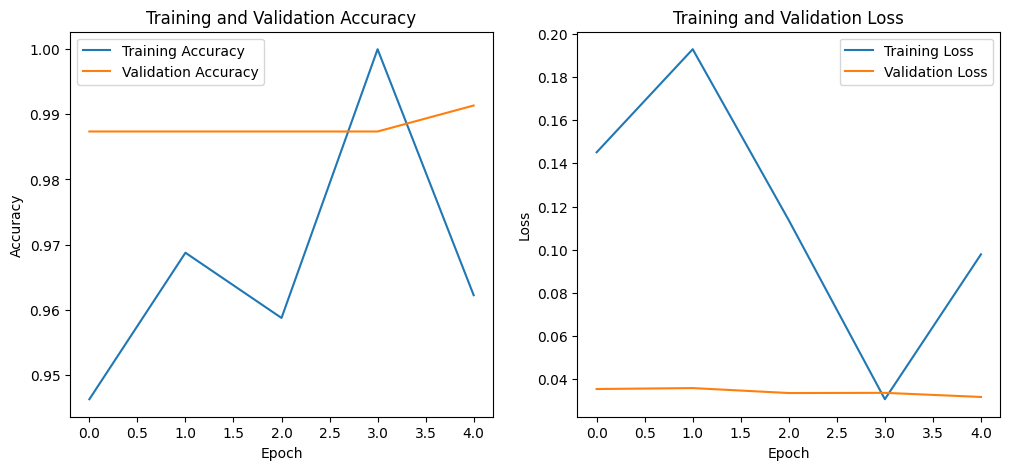

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

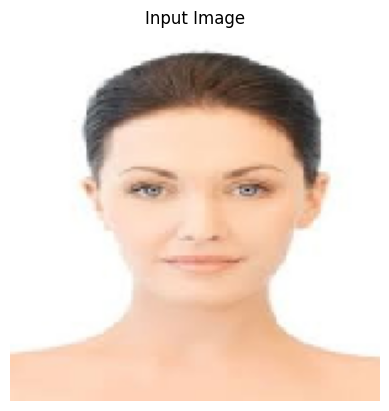

In [27]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load and display the image
img = image.load_img('data/test/without_mask/without_mask_1025.jpg', target_size=(img_width, img_height))
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('best_models.keras')

# Function to predict mask or no mask
def predict_mask(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Without Mask"
    else:
        return "With Mask"

# Test the function
image_path = 'data/test/without_mask/without_mask_1025.jpg'
print(predict_mask(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Without Mask


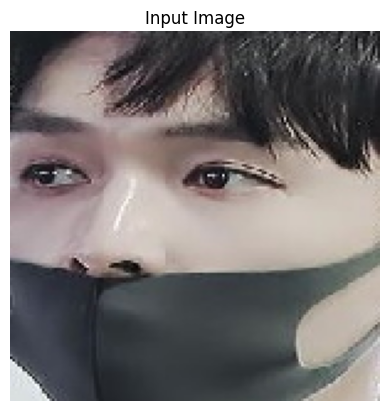

In [36]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load and display the image
img = image.load_img('data/test/with_mask/with_mask_1021.jpg', target_size=(img_width, img_height))
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('best_models.keras')

# Function to predict mask or no mask
def predict_mask(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Without Mask"
    else:
        return "With Mask"

# Test the function
image_path = 'data/test/with_mask/with_mask_1021.jpg'
print(predict_mask(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
With Mask


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Get input shape of the model
model = tf.keras.models.load_model('best_models.keras')
_, img_width, img_height, _ = model.input_shape  # Extract correct dimensions

def predict_mask(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))  # Resize correctly
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Without Mask"
    else:
        return "With Mask"

# Test
image_path = 'facee.png'
print(predict_mask(image_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
With Mask


In [7]:
!pip install opencv-python tensorflow numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import cv2

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [1]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
try:
    model = tf.keras.models.load_model('best_model.keras')
    print(" Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the webcam
cap = cv2.VideoCapture(0)  # Use 0 for the default camera
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

if not cap.isOpened():
    print("Error: Could not access the webcam!")
    exit()

print("🎥 Webcam started. Press 'Q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from webcam!")
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

    for (x, y, w, h) in faces:
        # Extract and preprocess face
        face = frame[y:y+h, x:x+w]
        resized_face = cv2.resize(face, (150, 150))  # Resize to model input size
        resized_face = resized_face / 255.0  # Normalize
        resized_face = np.expand_dims(resized_face, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(resized_face)[0][0]  # Get first value
        label = "Mask" if prediction < 0.5 else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)  # Green for mask, red for no mask

        # Draw bounding box & label
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Show the video feed
    cv2.imshow('Face Mask Detection', frame)

    # Exit on 'q' key or if window is closed
    if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty('Face Mask Detection', cv2.WND_PROP_VISIBLE) < 1:
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("Webcam closed.")


 Model loaded successfully!
🎥 Webcam started. Press 'Q' to exit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━